<a href="https://colab.research.google.com/github/stefkong1982/netology.ru/blob/Master/SberMarket_Competition/Kondratev_SberMarket_Competition_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Описание**


Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.


## **Набор данных**

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

* user_id - уникальный id пользователя
* order_completed_at - дата заказа
* cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

* id - идентификатор строки - состоит из user_id и category_id, разделенных
точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
* target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя


##  1_Подготовка данных:

In [65]:
import pandas as pd
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

### Загрузка тренировочных данных

In [66]:
# Загрузка данных
X_data = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/train.csv')
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


In [67]:
# Загрузка данных
sub_df = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/sample_submission.csv')
sub_df

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [68]:
# Удаление столбца 'target' из DataFrame 'sub_df'
sub_df.drop('target', axis=1, inplace=True)

# Вывод "очищенного" DataFrame для проверки
sub_df


,id
0,0;133
1,0;5
2,0;10
3,0;396
4,0;14
...,...
790444,19998;26
790445,19998;31
790446,19998;29
790447,19998;798


In [69]:
# Отсортируем данные по дате
X_data = X_data.sort_values(by='order_completed_at', ascending=True)

In [70]:
X_data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
15,2,2015-03-22 09:25:46,425
14,2,2015-03-22 09:25:46,57
13,2,2015-03-22 09:25:46,89
11,2,2015-03-22 09:25:46,84
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


In [71]:
# Выделяем последние строки для X_test
X_t = X_data[-790449:]

In [72]:
X_t

,user_id,order_completed_at,cart
2332626,17901,2020-07-13 11:35:28,423
2332625,17901,2020-07-13 11:35:28,798
2332624,17901,2020-07-13 11:35:28,61
2332623,17901,2020-07-13 11:35:28,421
2332622,17901,2020-07-13 11:35:28,41
...,...,...,...
3123036,12702,2020-09-03 23:45:45,54
3123034,12702,2020-09-03 23:45:45,382
3123062,12702,2020-09-03 23:45:45,24
3123047,12702,2020-09-03 23:45:45,376


In [73]:
# Убираем столбец order_completed_at
X_t.drop('order_completed_at', axis=1, inplace=True)

In [33]:
X_t

,user_id,cart
2332626,17901,423
2332625,17901,798
2332624,17901,61
2332623,17901,421
2332622,17901,41
...,...,...
3123036,12702,54
3123034,12702,382
3123062,12702,24
3123047,12702,376


In [ ]:
"""
# Выделяем все строки кроме последних для X_small
X_small = X_data[:-790449]
"""

'\n# Выделяем все строки кроме последних для X_small\nX_small = X_data[:-790449]\n'

In [74]:
X_small = X_data[:2332615]

In [75]:
X_small

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
15,2,2015-03-22 09:25:46,425
14,2,2015-03-22 09:25:46,57
13,2,2015-03-22 09:25:46,89
11,2,2015-03-22 09:25:46,84
...,...,...,...
2332601,9333,2020-07-13 11:34:50,26
2332599,9333,2020-07-13 11:34:50,394
2332629,17901,2020-07-13 11:35:28,26
2332621,17901,2020-07-13 11:35:28,408


In [76]:
# Убираем столбец order_completed_at
X_small.drop('order_completed_at', axis=1, inplace=True)

In [77]:
X_small

,user_id,cart
0,2,399
15,2,425
14,2,57
13,2,89
11,2,84
...,...,...
2332601,9333,26
2332599,9333,394
2332629,17901,26
2332621,17901,408


In [78]:
# Добавляем столбец target со значениями 1
X_small['target'] = 1

In [39]:
X_small

,user_id,cart,target
0,2,399,1
15,2,425,1
14,2,57,1
13,2,89,1
11,2,84,1
...,...,...,...
2332601,9333,26,1
2332599,9333,394,1
2332629,17901,26,1
2332621,17901,408,1


In [79]:
# Создаем новый столбец 'id', объединяя 'user_id' и 'cart', разделенные точкой с запятой
X_small['id'] = X_small.apply(lambda row: f"{row['user_id']};{row['cart']}", axis=1)

X_small

,user_id,cart,target,id
0,2,399,1,2;399
15,2,425,1,2;425
14,2,57,1,2;57
13,2,89,1,2;89
11,2,84,1,2;84
...,...,...,...,...
2332601,9333,26,1,9333;26
2332599,9333,394,1,9333;394
2332629,17901,26,1,17901;26
2332621,17901,408,1,17901;408


In [80]:
# Объединение датафреймов по столбцу 'id'
X_small = pd.merge(X_small, sub_df, on='id')

In [81]:
X_small

,user_id,cart,target,id
0,3,399,1,3;399
1,3,399,1,3;399
2,3,399,1,3;399
3,4,54,1,4;54
4,4,54,1,4;54
...,...,...,...,...
1717452,11582,89,1,11582;89
1717453,2104,10,1,2104;10
1717454,2104,376,1,2104;376
1717455,2104,99,1,2104;99


In [82]:
X_small = X_small.drop_duplicates(subset=['id'])


X_small


,user_id,cart,target,id
0,3,399,1,3;399
3,4,54,1,4;54
7,4,55,1,4;55
8,5,389,1,5;389
9,5,84,1,5;84
...,...,...,...,...
1717452,11582,89,1,11582;89
1717453,2104,10,1,2104;10
1717454,2104,376,1,2104;376
1717455,2104,99,1,2104;99


In [83]:
import itertools

# Получаем уникальные значения user_id и cart
unique_user_ids = X_small['user_id'].unique()
unique_carts = X_small['cart'].unique()

# Создаем все возможные комбинации user_id и cart
all_combinations = list(itertools.product(unique_user_ids, unique_carts))

# Создаем DataFrame с этими комбинациями
combinations_df = pd.DataFrame(all_combinations, columns=['user_id', 'cart'])

combinations_df

,user_id,cart
0,3,399
1,3,54
2,3,55
3,3,389
4,3,84
...,...,...
9204143,18611,269
9204144,18611,779
9204145,18611,730
9204146,18611,757


In [ ]:
combinations_df['id'] = combinations_df.apply(lambda row: f"{row['user_id']};{row['cart']}", axis=1)

combinations_df


In [1]:
merged_X_small = X_small.merge(combinations_df, on='id', how='outer')
merged_X_small

NameError: name 'X_small' is not defined

In [49]:
merged_X_small['target'].fillna(0, inplace=True)
merged_X_small



,id,user_id_x,cart_x,target,id_count,user_id_y,cart_y
0,10000;0,10000.0,0.0,1.0,2.0,10000,0
1,10000;14,10000.0,14.0,1.0,2.0,10000,14
2,10000;15,10000.0,15.0,1.0,1.0,10000,15
3,10000;157,10000.0,157.0,1.0,1.0,10000,157
4,10000;158,10000.0,158.0,1.0,1.0,10000,158
...,...,...,...,...,...,...,...
9204143,9;636,NaN,NaN,0.0,0.0,9,636
9204144,9;348,NaN,NaN,0.0,0.0,9,348
9204145,9;675,NaN,NaN,0.0,0.0,9,675
9204146,9;629,NaN,NaN,0.0,0.0,9,629


In [50]:
merged_X_small = merged_X_small[['id', 'target', 'user_id_y', 'cart_y']]

merged_X_small


,id,target,id_count,user_id_y,cart_y
0,10000;0,1.0,2.0,10000,0
1,10000;14,1.0,2.0,10000,14
2,10000;15,1.0,1.0,10000,15
3,10000;157,1.0,1.0,10000,157
4,10000;158,1.0,1.0,10000,158
...,...,...,...,...,...
9204143,9;636,0.0,0.0,9,636
9204144,9;348,0.0,0.0,9,348
9204145,9;675,0.0,0.0,9,675
9204146,9;629,0.0,0.0,9,629


In [51]:
merged_X_small.columns = ['id', 'target', 'id_count', 'user_id', 'cart']

In [52]:
merged_X_small

,id,target,id_count,user_id,cart
0,10000;0,1.0,2.0,10000,0
1,10000;14,1.0,2.0,10000,14
2,10000;15,1.0,1.0,10000,15
3,10000;157,1.0,1.0,10000,157
4,10000;158,1.0,1.0,10000,158
...,...,...,...,...,...
9204143,9;636,0.0,0.0,9,636
9204144,9;348,0.0,0.0,9,348
9204145,9;675,0.0,0.0,9,675
9204146,9;629,0.0,0.0,9,629


In [53]:
X_s = merged_X_small[['id_count', 'user_id', 'cart']]

In [54]:
X_s

,id_count,user_id,cart
0,2.0,10000,0
1,2.0,10000,14
2,1.0,10000,15
3,1.0,10000,157
4,1.0,10000,158
...,...,...,...
9204143,0.0,9,636
9204144,0.0,9,348
9204145,0.0,9,675
9204146,0.0,9,629


In [ ]:
"""
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_s)
    inertia.append(kmeans.inertia_)
"""

'\nfrom sklearn.cluster import KMeans\nimport matplotlib.pyplot as plt\nimport warnings\n\nwarnings.filterwarnings("ignore")\n\ninertia = []\nfor k in range(1, 10):\n    kmeans = KMeans(n_clusters=k, random_state=0)\n    kmeans.fit(X_s)\n    inertia.append(kmeans.inertia_)\n'

In [ ]:
"""
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для merged_X_small')
plt.show()
"""

"\nplt.plot(range(1, 10), inertia, marker='o')\nplt.xlabel('Число кластеров')\nplt.ylabel('Инерция')\nplt.title('Метод локтя для merged_X_small')\nplt.show()\n"

In [55]:
warnings.filterwarnings("ignore")

optimal_n_clusters = 3
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=0)
merged_X_small['cluster'] = kmeans.fit_predict(X_s)


In [56]:
merged_X_small

,id,target,id_count,user_id,cart,cluster
0,10000;0,1.0,2.0,10000,0,2
1,10000;14,1.0,2.0,10000,14,2
2,10000;15,1.0,1.0,10000,15,2
3,10000;157,1.0,1.0,10000,157,2
4,10000;158,1.0,1.0,10000,158,2
...,...,...,...,...,...,...
9204143,9;636,0.0,0.0,9,636,1
9204144,9;348,0.0,0.0,9,348,1
9204145,9;675,0.0,0.0,9,675,1
9204146,9;629,0.0,0.0,9,629,1


In [57]:

# Сохраняем DataFrame 'final_df' в CSV файл
merged_X_small.to_csv('merged_X_small.csv', index=False)


In [58]:

from google.colab import files
files.download('merged_X_small.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Загрузка данных
merged_X_small = pd.read_csv('merged_X_small.csv')
merged_X_small

,id,target,id_count,user_id,cart,cluster
0,10000;0,1.0,2.0,10000,0,2
1,10000;14,1.0,2.0,10000,14,2
2,10000;15,1.0,1.0,10000,15,2
3,10000;157,1.0,1.0,10000,157,2
4,10000;158,1.0,1.0,10000,158,2
...,...,...,...,...,...,...
9204143,9;636,0.0,0.0,9,636,1
9204144,9;348,0.0,0.0,9,348,1
9204145,9;675,0.0,0.0,9,675,1
9204146,9;629,0.0,0.0,9,629,1


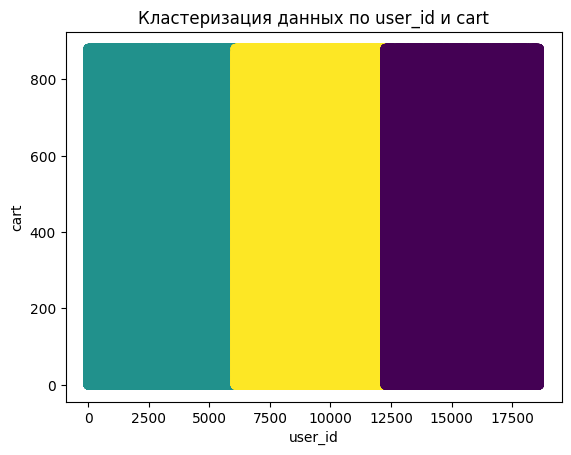

In [60]:

# визуализация кластеров
plt.scatter(merged_X_small['user_id'], merged_X_small['cart'], c=merged_X_small['cluster'], cmap='viridis')
plt.xlabel('user_id')
plt.ylabel('cart')
plt.title('Кластеризация данных по user_id и cart')
plt.show()


In [61]:
X = merged_X_small[['cart', 'user_id', 'cluster']]
y = merged_X_small['target']


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()


In [64]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Предсказания на тестовом наборе данных
predictions = model.predict(X_test)

# Оценка точности модели с помощью MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Оценка точности модели с помощью R²
r2 = r2_score(y_test, predictions)
print(f'R² Score: {r2}')

# Оценка точности модели с помощью MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 0.08600079605267673
R² Score: -0.02074955934948064
Mean Squared Error: 0.059429726391204994


In [ ]:
# Добавление предсказаний в новый столбец 'predictions'
merged_X_small['predictions'] = model.predict(X)

In [ ]:
merged_X_small

,id,target,id_count,user_id,cart,cluster,predictions
0,1000;14,1.0,2.0,1000,14,0,1.00
1,1000;149,1.0,1.0,1000,149,0,0.89
2,1000;157,1.0,1.0,1000,157,0,0.61
3,1000;165,1.0,1.0,1000,165,0,0.92
4,1000;169,1.0,1.0,1000,169,0,0.78
...,...,...,...,...,...,...,...
1457185,9;38,0.0,0.0,9,38,0,0.00
1457186,9;348,0.0,0.0,9,348,0,0.00
1457187,9;250,0.0,0.0,9,250,0,0.00
1457188,9;507,0.0,0.0,9,507,0,0.00


In [ ]:
# Добавление столбца 'order_prediction' в merged_X_small на основе порогового значения
merged_X_small['order_prediction'] = merged_X_small['predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Вывод обновленного датафрейма
merged_X_small


,id,target,id_count,user_id,cart,cluster,predictions,order_prediction
0,1000;14,1.0,2.0,1000,14,0,1.00,1
1,1000;149,1.0,1.0,1000,149,0,0.89,1
2,1000;157,1.0,1.0,1000,157,0,0.61,1
3,1000;165,1.0,1.0,1000,165,0,0.92,1
4,1000;169,1.0,1.0,1000,169,0,0.78,1
...,...,...,...,...,...,...,...,...
1457185,9;38,0.0,0.0,9,38,0,0.00,0
1457186,9;348,0.0,0.0,9,348,0,0.00,0
1457187,9;250,0.0,0.0,9,250,0,0.00,0
1457188,9;507,0.0,0.0,9,507,0,0.00,0


In [ ]:

# Истинные значения 'target' из новых данных
true_values = merged_X_small['target']

# Предсказания модели
predicted_values = merged_X_small['predictions']

# Вычисление MSE и R^2
mse = mean_squared_error(true_values, predicted_values)
r2 = r2_score(true_values, predicted_values)

print(f'MSE на новых данных: {mse}')
print(f'R^2 на новых данных: {r2}')


MSE на новых данных: 0.018569094833206373
R^2 на новых данных: 0.6856457477487161


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Оценка точности предсказаний 'target' с использованием порогового значения 0.5
merged_X_small['predicted_target'] = merged_X_small['order_prediction']  # Предсказания 'target'
true_target = merged_X_small['target']  # Истинные значения 'target'

# Расчет метрик точности и F1-меры
accuracy = accuracy_score(true_target, merged_X_small['predicted_target'])
f1 = f1_score(true_target, merged_X_small['predicted_target'])

print(f'Accuracy предсказаний target: {accuracy}')
print(f'F1-мера предсказаний target: {f1}')


# Вычисление MSE и R² для предсказаний значения 'target'
mse_target = mean_squared_error(true_target, merged_X_small['predicted_target'])
r2_target = r2_score(true_target, merged_X_small['predicted_target'])

print(f'MSE предсказаний target: {mse_target}')
print(f'R^2 предсказаний target: {r2_target}')


Accuracy предсказаний target: 0.9839135596593444
F1-мера предсказаний target: 0.8710935137067282
MSE предсказаний target: 0.016086440340655647
R^2 предсказаний target: 0.7276743443827565


In [ ]:
X_t

,user_id,cart,id
2332626,17901,423,17901;423
2332625,17901,798,17901;798
2332624,17901,61,17901;61
2332623,17901,421,17901;421
2332622,17901,41,17901;41
...,...,...,...
3123036,12702,54,12702;54
3123034,12702,382,12702;382
3123062,12702,24,12702;24
3123047,12702,376,12702;376


In [ ]:
# Создание нового столбца 'id' путем объединения 'user_id' и 'category_id' (в данном случае 'cart')
X_t['id'] = X_t['user_id'].astype(str) + ';' + X_t['cart'].astype(str)

# Вывод обновленного датафрейма с добавленным столбцом 'id'
X_t


,user_id,cart,id
2332626,17901,423,17901;423
2332625,17901,798,17901;798
2332624,17901,61,17901;61
2332623,17901,421,17901;421
2332622,17901,41,17901;41
...,...,...,...
3123036,12702,54,12702;54
3123034,12702,382,12702;382
3123062,12702,24,12702;24
3123047,12702,376,12702;376


In [ ]:
# Удаление столбцов 'user_id' и 'cart' из датафрейма
X_t.drop(['user_id', 'cart'], axis=1, inplace=True)

# Вывод обновленного датафрейма без столбцов 'user_id' и 'cart'
X_t


,id
2332626,17901;423
2332625,17901;798
2332624,17901;61
2332623,17901;421
2332622,17901;41
...,...
3123036,12702;54
3123034,12702;382
3123062,12702;24
3123047,12702;376


In [ ]:
# Добавление столбца 'targ' со значениями 1
X_t['targ'] = 1

# Вывод обновленного датафрейма с добавленным столбцом 'targ'
X_t


,id,targ
2332626,17901;423,1
2332625,17901;798,1
2332624,17901;61,1
2332623,17901;421,1
2332622,17901;41,1
...,...,...
3123036,12702;54,1
3123034,12702;382,1
3123062,12702;24,1
3123047,12702;376,1


In [ ]:
# Объединение DataFrame по столбцу 'id' и оставление только строк, соответствующих sub_df
new_df = pd.merge(merged_X_small, X_t, on='id', how='inner')

In [ ]:
new_df

,id,target,id_count,user_id,cart,cluster,predictions,order_prediction,predicted_target,targ
0,1002;0,1.0,1.0,1002,0,0,0.67,1,1,1
1,1002;100,1.0,1.0,1002,100,0,0.01,0,0,1
2,1002;14,1.0,14.0,1002,14,0,1.00,1,1,1
3,1002;14,1.0,14.0,1002,14,0,1.00,1,1,1
4,1002;14,1.0,14.0,1002,14,0,1.00,1,1,1
...,...,...,...,...,...,...,...,...,...,...
103887,99;16,0.0,0.0,99,16,0,0.05,0,0,1
103888,99;383,0.0,0.0,99,383,0,0.35,0,0,1
103889,99;440,0.0,0.0,99,440,0,0.26,0,0,1
103890,99;54,0.0,0.0,99,54,0,0.24,0,0,1


In [ ]:
# Удаление лишних столбцов из DataFrame final_df
new_df = new_df.drop(['target', 'predictions', 'order_prediction', 'predicted_target', ], axis=1)

new_df

,id,id_count,user_id,cart,cluster,targ
0,1002;0,1.0,1002,0,0,1
1,1002;100,1.0,1002,100,0,1
2,1002;14,14.0,1002,14,0,1
3,1002;14,14.0,1002,14,0,1
4,1002;14,14.0,1002,14,0,1
...,...,...,...,...,...,...
103887,99;16,0.0,99,16,0,1
103888,99;383,0.0,99,383,0,1
103889,99;440,0.0,99,440,0,1
103890,99;54,0.0,99,54,0,1


In [ ]:
# Подготовка данных для предсказания на новых данных
X_new = new_df[['cart', 'user_id', 'cluster']]

# Делаем предсказания на новых данных и сразу переименовываем столбец
new_df['predictions'] = model.predict(X_new)

new_df

,id,id_count,user_id,cart,cluster,targ,predictions
0,1002;0,1.0,1002,0,0,1,0.67
1,1002;100,1.0,1002,100,0,1,0.01
2,1002;14,14.0,1002,14,0,1,1.00
3,1002;14,14.0,1002,14,0,1,1.00
4,1002;14,14.0,1002,14,0,1,1.00
...,...,...,...,...,...,...,...
103887,99;16,0.0,99,16,0,1,0.05
103888,99;383,0.0,99,383,0,1,0.35
103889,99;440,0.0,99,440,0,1,0.26
103890,99;54,0.0,99,54,0,1,0.24


In [ ]:
# Создание столбца 'target' на основе predictions
new_df['target'] = new_df['predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Вывод обновленного датафрейма
new_df


,id,id_count,user_id,cart,cluster,targ,predictions,target
0,1002;0,1.0,1002,0,0,1,0.67,1
1,1002;100,1.0,1002,100,0,1,0.01,0
2,1002;14,14.0,1002,14,0,1,1.00,1
3,1002;14,14.0,1002,14,0,1,1.00,1
4,1002;14,14.0,1002,14,0,1,1.00,1
...,...,...,...,...,...,...,...,...
103887,99;16,0.0,99,16,0,1,0.05,0
103888,99;383,0.0,99,383,0,1,0.35,0
103889,99;440,0.0,99,440,0,1,0.26,0
103890,99;54,0.0,99,54,0,1,0.24,0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Истинные значения 'targ' из новых данных
true_targ = new_df['targ']

# Предсказанные значения 'target'
predicted_target = new_df['target']

# Оценка точности и F1-меры
accuracy_new = accuracy_score(true_targ, predicted_target)
f1_new = f1_score(true_targ, predicted_target)

print(f'Accuracy предсказаний target на новых данных: {accuracy_new}')
print(f'F1-мера предсказаний target на новых данных: {f1_new}')


Accuracy предсказаний target на новых данных: 0.47976745081430716
F1-мера предсказаний target на новых данных: 0.6484362803767498


In [ ]:
# Загрузка данных
sub_df = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/sample_submission.csv')
sub_df

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [ ]:
# Удаление столбца 'target' из DataFrame 'sub_df'
sub_df.drop('target', axis=1, inplace=True)

# Вывод "очищенного" DataFrame для проверки
sub_df


In [ ]:
# Объединение DataFrame по столбцу 'id' и оставление только строк, соответствующих sub_df
final_df = pd.merge(merged_X_small, sub_df, on='id', how='inner')

In [ ]:
final_df

In [ ]:
# Удаление лишних столбцов из DataFrame final_df
final_df = final_df.drop(['target', 'predictions'], axis=1)

final_df


,id,id_count,user_id,cart,cluster
0,10000;0,2.0,10000,0,2
1,10000;14,2.0,10000,14,2
2,10000;15,1.0,10000,15,2
3,10000;157,1.0,10000,157,2
4,10000;158,1.0,10000,158,2
...,...,...,...,...,...
735896,9997;160,0.0,9997,160,2
735897,9997;340,0.0,9997,340,2
735898,9997;219,0.0,9997,219,2
735899,9997;809,0.0,9997,809,2


In [ ]:
# Подготовка данных для предсказания на новых данных
X_final = final_df[['user_id', 'cart', 'cluster']]

# Делаем предсказания на новых данных и сразу переименовываем столбец
final_df['target'] = model.predict(X_final)

final_df


,id,id_count,user_id,cart,cluster,target
0,10000;0,2.0,10000,0,2,1.0
1,10000;14,2.0,10000,14,2,1.0
2,10000;15,1.0,10000,15,2,1.0
3,10000;157,1.0,10000,157,2,1.0
4,10000;158,1.0,10000,158,2,1.0
...,...,...,...,...,...,...
735896,9997;160,0.0,9997,160,2,0.0
735897,9997;340,0.0,9997,340,2,0.0
735898,9997;219,0.0,9997,219,2,0.0
735899,9997;809,0.0,9997,809,2,0.0


In [ ]:
# Оставляем только столбцы 'id' и 'target' в DataFrame final_df
final_df = final_df[['id', 'target']]

final_df


,id,target
0,10000;0,1.0
1,10000;14,1.0
2,10000;15,1.0
3,10000;157,1.0
4,10000;158,1.0
...,...,...
735896,9997;160,0.0
735897,9997;340,0.0
735898,9997;219,0.0
735899,9997;809,0.0


In [ ]:
# Сохраняем DataFrame 'final_df' в CSV файл
final_df.to_csv('final_predictions.csv', index=False)



In [ ]:
from google.colab import files
files.download('final_predictions.csv')


In [ ]:
# Загрузка данных
final_p = pd.read_csv('https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/SberMarket_Competition/final_predictions.csv')
final_p

,id,target
0,0;10,1.0
1,0;133,1.0
2,0;14,1.0
3,0;157,1.0
4,0;169,1.0
...,...,...
790444,9;87,1.0
790445,9;89,1.0
790446,9;9,1.0
790447,9;96,1.0


In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2fb99c78f30bdfa38746fbb75bb2cbec54171f6d51e7cdc9adfd5fb1f9f413ef
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName('target_prediction').getOrCreate()


In [ ]:
merged_X_small

,id,target,id_count,user_id,cart,cluster,predictions,order_prediction,predicted_target
0,1000;14,1.0,2.0,1000,14,0,1.00,1,1
1,1000;149,1.0,1.0,1000,149,0,0.89,1,1
2,1000;157,1.0,1.0,1000,157,0,0.61,1,1
3,1000;165,1.0,1.0,1000,165,0,0.92,1,1
4,1000;169,1.0,1.0,1000,169,0,0.78,1,1
...,...,...,...,...,...,...,...,...,...
1457185,9;38,0.0,0.0,9,38,0,0.00,0,0
1457186,9;348,0.0,0.0,9,348,0,0.00,0,0
1457187,9;250,0.0,0.0,9,250,0,0.00,0,0
1457188,9;507,0.0,0.0,9,507,0,0.00,0,0


In [ ]:
# Преобразовать pandas DataFrame в Spark DataFrame
merged_X_small_spark = spark.createDataFrame(merged_X_small)

In [ ]:


# Выбрать нужные столбцы
data = merged_X_small_spark.select('id', 'user_id', 'cart', 'cluster', 'target')

# Подготовка признаков
assembler = VectorAssembler(inputCols=['user_id', 'cart', 'cluster'], outputCol='features')
data = assembler.transform(data)


In [ ]:
merged_X_small_spark.show(5)

+--------+------+--------+-------+----+-------+-----------+----------------+----------------+
|      id|target|id_count|user_id|cart|cluster|predictions|order_prediction|predicted_target|
+--------+------+--------+-------+----+-------+-----------+----------------+----------------+
| 1000;14|   1.0|     2.0|   1000|  14|      0|        1.0|               1|               1|
|1000;149|   1.0|     1.0|   1000| 149|      0|       0.89|               1|               1|
|1000;157|   1.0|     1.0|   1000| 157|      0|       0.61|               1|               1|
|1000;165|   1.0|     1.0|   1000| 165|      0|       0.92|               1|               1|
|1000;169|   1.0|     1.0|   1000| 169|      0|       0.78|               1|               1|
+--------+------+--------+-------+----+-------+-----------+----------------+----------------+
only showing top 5 rows



In [ ]:
data.show(5)

+--------+-------+----+-------+------+------------------+
|      id|user_id|cart|cluster|target|          features|
+--------+-------+----+-------+------+------------------+
| 1000;14|   1000|  14|      0|   1.0| [1000.0,14.0,0.0]|
|1000;149|   1000| 149|      0|   1.0|[1000.0,149.0,0.0]|
|1000;157|   1000| 157|      0|   1.0|[1000.0,157.0,0.0]|
|1000;165|   1000| 165|      0|   1.0|[1000.0,165.0,0.0]|
|1000;169|   1000| 169|      0|   1.0|[1000.0,169.0,0.0]|
+--------+-------+----+-------+------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Объединение признаков в один вектор
feature_columns = [col for col in data.columns if col != 'label']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Переименовать столбец 'target' в 'label'
data_transformed = data.withColumnRenamed('target', 'label')

# Разделить данные на обучающий и тестовый набор
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Обучить модель RandomForestRegressor и сделать предсказания
rf = RandomForestRegressor()
model = rf.fit(train_data)
predictions = model.transform(test_data)


In [ ]:
feature_columns

['id', 'user_id', 'cart', 'cluster', 'target', 'features']

In [ ]:
from pyspark.sql import functions as F

# Переименовать столбец 'target' в 'label'
data = data.withColumnRenamed('target', 'label')

# Разделить данные на обучающий и тестовый набор
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Обучить модель RandomForestRegressor и сделать предсказания
rf = RandomForestRegressor()
model = rf.fit(train_data)
predictions = model.transform(test_data)


In [ ]:
train_data.show(20)

+--------+-------+----+-------+-----+------------------+
|      id|user_id|cart|cluster|label|          features|
+--------+-------+----+-------+-----+------------------+
|  1000;0|   1000|   0|      0|  0.0|  [1000.0,0.0,0.0]|
|  1000;1|   1000|   1|      0|  0.0|  [1000.0,1.0,0.0]|
|1000;100|   1000| 100|      0|  0.0|[1000.0,100.0,0.0]|
|1000;101|   1000| 101|      0|  0.0|[1000.0,101.0,0.0]|
|1000;102|   1000| 102|      0|  0.0|[1000.0,102.0,0.0]|
|1000;104|   1000| 104|      0|  0.0|[1000.0,104.0,0.0]|
|1000;106|   1000| 106|      0|  0.0|[1000.0,106.0,0.0]|
|1000;107|   1000| 107|      0|  0.0|[1000.0,107.0,0.0]|
|1000;108|   1000| 108|      0|  0.0|[1000.0,108.0,0.0]|
|1000;109|   1000| 109|      0|  0.0|[1000.0,109.0,0.0]|
|1000;110|   1000| 110|      0|  0.0|[1000.0,110.0,0.0]|
|1000;111|   1000| 111|      0|  0.0|[1000.0,111.0,0.0]|
|1000;112|   1000| 112|      0|  0.0|[1000.0,112.0,0.0]|
|1000;113|   1000| 113|      0|  0.0|[1000.0,113.0,0.0]|
|1000;114|   1000| 114|      0|

In [ ]:
predictions.show(20)

+--------+-------+----+-------+-----+------------------+-------------------+
|      id|user_id|cart|cluster|label|          features|         prediction|
+--------+-------+----+-------+-----+------------------+-------------------+
| 1000;10|   1000|  10|      0|  0.0| [1000.0,10.0,0.0]|0.16974784862816258|
|1000;103|   1000| 103|      0|  0.0|[1000.0,103.0,0.0]|0.07343890171139233|
|1000;105|   1000| 105|      0|  0.0|[1000.0,105.0,0.0]|0.07343890171139233|
| 1000;11|   1000|  11|      0|  0.0| [1000.0,11.0,0.0]|0.16974784862816258|
|1000;115|   1000| 115|      0|  0.0|[1000.0,115.0,0.0]|0.07343890171139233|
|1000;119|   1000| 119|      0|  0.0|[1000.0,119.0,0.0]|0.07343890171139233|
|1000;124|   1000| 124|      0|  0.0|[1000.0,124.0,0.0]|0.07343890171139233|
| 1000;13|   1000|  13|      0|  0.0| [1000.0,13.0,0.0]|0.16974784862816258|
|1000;140|   1000| 140|      0|  0.0|[1000.0,140.0,0.0]|0.07343890171139233|
|1000;141|   1000| 141|      0|  0.0|[1000.0,141.0,0.0]|0.07343890171139233|

In [ ]:
# Создание оценщика
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)

evaluator.setMetricName('r2')
r2 = evaluator.evaluate(predictions)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


MSE: 0.05643846835680383
R^2: 0.04297964421638589


In [ ]:
# Импорт необходимых функций
from pyspark.sql import functions as F

# Добавить столбец 'target' на основе значения 'prediction'
threshold = 0.5
result = predictions.withColumn('target', F.when(F.col('prediction') >= threshold, 1).otherwise(0))

# Показать результат
result.show(20)


+--------+-------+----+-------+-----+------------------+-------------------+------+
|      id|user_id|cart|cluster|label|          features|         prediction|target|
+--------+-------+----+-------+-----+------------------+-------------------+------+
| 1000;10|   1000|  10|      0|  0.0| [1000.0,10.0,0.0]|0.16974784862816258|     0|
|1000;103|   1000| 103|      0|  0.0|[1000.0,103.0,0.0]|0.07343890171139233|     0|
|1000;105|   1000| 105|      0|  0.0|[1000.0,105.0,0.0]|0.07343890171139233|     0|
| 1000;11|   1000|  11|      0|  0.0| [1000.0,11.0,0.0]|0.16974784862816258|     0|
|1000;115|   1000| 115|      0|  0.0|[1000.0,115.0,0.0]|0.07343890171139233|     0|
|1000;119|   1000| 119|      0|  0.0|[1000.0,119.0,0.0]|0.07343890171139233|     0|
|1000;124|   1000| 124|      0|  0.0|[1000.0,124.0,0.0]|0.07343890171139233|     0|
| 1000;13|   1000|  13|      0|  0.0| [1000.0,13.0,0.0]|0.16974784862816258|     0|
|1000;140|   1000| 140|      0|  0.0|[1000.0,140.0,0.0]|0.07343890171139233|

In [ ]:
from pyspark.sql import functions as F

# Сравнение фактического значения с предсказанным и подсчет количества верных предсказаний
correct_predictions = result.withColumn('correct', F.col('label') == F.col('target')).filter(F.col('correct') == True).count()

# Вычисление процента верных предсказаний
total_records = result.count()
accuracy = (correct_predictions / total_records) * 100

# Вывод процента верных предсказаний
print("Процент верных предсказаний: {:.2f}%".format(accuracy))


Процент верных предсказаний: 93.71%


In [ ]:
X_t

,id,targ
2332626,17901;423,1
2332625,17901;798,1
2332624,17901;61,1
2332623,17901;421,1
2332622,17901;41,1
...,...,...
3123036,12702;54,1
3123034,12702;382,1
3123062,12702;24,1
3123047,12702;376,1


In [ ]:
# Преобразовать Pandas DataFrame X_t в Spark DataFrame
spark_X_t = spark.createDataFrame(X_t)

In [ ]:
# Показать структуру и содержание Spark DataFrame
spark_X_t.show()

+---------+----+
|       id|targ|
+---------+----+
|17901;423|   1|
|17901;798|   1|
| 17901;61|   1|
|17901;421|   1|
| 17901;41|   1|
| 17901;23|   1|
|17901;169|   1|
|17901;232|   1|
|17901;388|   1|
|17901;389|   1|
|17901;398|   1|
|17901;382|   1|
| 17901;89|   1|
|17901;420|   1|
|17901;396|   1|
|16178;402|   1|
|16178;126|   1|
| 16178;30|   1|
| 16178;99|   1|
|16178;100|   1|
+---------+----+
only showing top 20 rows



In [ ]:
# Узнать количество строк в DataFrame spark_X_t

row_c = spark_X_t.count()

print("Количество строк:", row_c)

Количество строк: 790449


In [ ]:
# Присоединить DataFrame X_t_with_id к DataFrame result по столбцу 'id'
joined_df = result.join(spark_X_t, 'id', 'inner')

# Показать результат
joined_df.show()


+--------+-------+----+-------+-----+------------------+-------------------+------+----+
|      id|user_id|cart|cluster|label|          features|         prediction|target|targ|
+--------+-------+----+-------+-----+------------------+-------------------+------+----+
| 1002;13|   1002|  13|      0|  0.0| [1002.0,13.0,0.0]|0.16974784862816258|     0|   1|
| 1002;13|   1002|  13|      0|  0.0| [1002.0,13.0,0.0]|0.16974784862816258|     0|   1|
| 1002;13|   1002|  13|      0|  0.0| [1002.0,13.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  16|      0|  1.0| [1002.0,16.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  16|      0|  1.0| [1002.0,16.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  16|      0|  1.0| [1002.0,16.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  16|      0|  1.0| [1002.0,16.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  16|      0|  1.0| [1002.0,16.0,0.0]|0.16974784862816258|     0|   1|
| 1002;16|   1002|  1

In [ ]:
# Узнать количество строк в DataFrame joined_df

row_c = joined_df.count()

print("Количество строк:", row_c)

Количество строк: 20876


In [ ]:
# Выбрать нужные столбцы
df = joined_df.select('id', 'user_id', 'cart', 'cluster', 'targ')

# Подготовка признаков
assembler = VectorAssembler(inputCols=['user_id', 'cart', 'cluster'], outputCol='features')
df = assembler.transform(df)

In [ ]:
df.show()

+--------+-------+----+-------+----+------------------+
|      id|user_id|cart|cluster|targ|          features|
+--------+-------+----+-------+----+------------------+
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|
|1002;169|   1002| 169|      0|   1|[1002.0,169.0,0.0]|
|1002;169|   1002| 169|      0|   1|[1002.0,169.0,0.0]|
|1002;172|   1002| 172|      0|   1|[1002.0,172.0,0.0]|
| 1002;23|   1002|  23|      0|   1| [1002.0,23.0,0.0]|
| 1002;23|   1002|  23|      0|   1| [1002.0,23.

In [ ]:


# Применить модель к данным с признаками
predictions_filtered_df = model.transform(df)

# Показать результат
predictions_filtered_df.show()


+--------+-------+----+-------+----+------------------+-------------------+
|      id|user_id|cart|cluster|targ|          features|         prediction|
+--------+-------+----+-------+----+------------------+-------------------+
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|
|1002;169|  

In [ ]:
# Импорт необходимых функций
from pyspark.sql import functions as F

# Добавить столбец 'target' на основе значения 'prediction'
threshold = 0.5
res = predictions_filtered_df.withColumn('target', F.when(F.col('prediction') >= threshold, 1).otherwise(0))

# Показать результат
res.show(20)

+--------+-------+----+-------+----+------------------+-------------------+------+
|      id|user_id|cart|cluster|targ|          features|         prediction|target|
+--------+-------+----+-------+----+------------------+-------------------+------+
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|     0|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|     0|
| 1002;13|   1002|  13|      0|   1| [1002.0,13.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 1002;16|   1002|  16|      0|   1| [1002.0,16.0,0.0]|0.16974784862816258|     0|
| 10

In [ ]:
# Сравнение фактического значения с предсказанным и подсчет количества верных предсказаний
correct_pred = res.withColumn('correct', F.col('targ') == F.col('target')).filter(F.col('correct') == True).count()

# Вычисление процента верных предсказаний
total_rec = res.count()
acc = (correct_pred / total_rec) * 100

# Вывод процента верных предсказаний
print("Процент верных предсказаний: {:.2f}%".format(acc))

Процент верных предсказаний: 0.00%
